### Machine Learning Assignment 1 - Iter 3
### Advait Rajagopal

### Imports and specifications to begin

In [1]:
# imports and specifications
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

#To validate/cross validate--create training and test data
from sklearn.cross_validation import train_test_split

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Performance measures 

In [2]:
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels)], axis=1)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['preds'].sum()
        self.performance_measures['Neg'] = self.performance_df.shape[0] - self.performance_df['preds'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])

### Read in the Raw Test Data

In [3]:
amazon = pd.read_csv('raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [4]:
#Taking a look at the data to see what it contains
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      400196        411245  411246  B0040WCR6O  A3FFKU2MTCOBM1   
1       38020        110761  110762  B003XUJ3RK   AC2SMT7WEOBQM   
2      366458        192489  192490  B006GA666U  A39FOS1KTT1T8Z   
3       43625        544264  544265  B00125PX8Q  A1XZXAV5OXD08P   
4      211610        494698  494699  B000BZZKVS  A15P774MWM8W4R   

             ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0  new yorker "drealyea"                     0                       0      1   
1                   Bill                     0                       0      5   
2                 kendon                     0                       0      2   
3               Good 4 U                     0                       0      5   
4             D. Dutcher                     8                      11      2   

         Time                            Summary  \
0  1340323200           Overpriced, disapointing   
1  132

### Feature extraction on natural language data

### Using the Hashing Vectorizer 'pickle' to create the bag of words

In [5]:
hv = joblib.load('hv.pkl') # pickle
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

(91000, 131072)


### Using the Transformer 'pickle' to create the Tfidf matrix

In [6]:
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features


In [7]:
# features from Amazon.csv to add to feature set

##FEATURE 1 - REVIEW LENGTH
#create a new column called review length which shows the length of each review
amazon['reviewLen'] = amazon['Text'].str.len()

In [8]:
##FEATURE 2 - PROFILE NAME
#Use profile name
prof_name = amazon['ProfileName']

#THIS IS THE ACTUAL CODE - Create dataframe with names and frequences attached
df_name = pd.DataFrame({'names' : list(prof_name)})
df_name['freq'] = df_name.groupby('names')['names'].transform('count')
df_name
amazon['profile_freq'] = df_name['freq'] 

In [9]:
#FEATURE 3 - PROFILE LENGTH
amazon['profileLen'] = amazon['ProfileName'].str.len()

#delete NaN's
where_are_NaNs_1 = np.isnan(amazon['profileLen'])
amazon[where_are_NaNs_1] = 0

In [10]:
#FEATURE 4 - SCORE
print(type(amazon['Score']))



<class 'pandas.core.series.Series'>


In [11]:
#FEATURE 5 - SUMMARY LENGTH
amazon['summaryLen'] = amazon['Summary'].str.len()
#delete NaN's
where_are_NaNs_2 = np.isnan(amazon['summaryLen'])
amazon[where_are_NaNs_2] = 0

In [12]:
#FEATURES 6,7,8,9,10,11,12
#6 - Score - Profile frequency interaction
amazon['score_count'] = amazon['Score']*df_name['freq']
#delete NaN's
where_are_NaNs_3 = np.isnan(amazon['score_count'])
amazon[where_are_NaNs_3] = 0

#7 - Review length - Profile frequency interaction
amazon['revLen_count'] = amazon['reviewLen']*df_name['freq']
#delete NaN's
where_are_NaNs_4 = np.isnan(amazon['revLen_count'])
amazon[where_are_NaNs_4] = 0

#8 - Score - Review length interaction
amazon['score_revLen'] = amazon['Score']*amazon['reviewLen']

#9 - Score - Summary length interaction
amazon['score_sumLen'] = amazon['Score']*amazon['summaryLen']

#10 - Summary length - Profile frequency interaction
amazon['sumLen_count'] = amazon['summaryLen']*df_name['freq']
#delete NaN's
where_are_NaNs_5 = np.isnan(amazon['sumLen_count'])
amazon[where_are_NaNs_5] = 0

#11 - Time
#amazon['Time']

#12 - Exclamation points
df1 = pd.DataFrame(amazon['Summary'])
df1.columns = ['summary']
df1['count'] = df1.summary.str.count('!')


amazon['exclam'] = df1['count']
#delete NaN's
where_are_NaNs_6 = np.isnan(amazon['exclam'])
amazon[where_are_NaNs_6] = 0

In [13]:
##Create a Features Matrix (with only the created features)

X_features = amazon[["reviewLen", 
                     "profile_freq",
                     "profileLen",
                     "Score",
                     "summaryLen",
                     "score_count",
                     "revLen_count",
                     "score_revLen",
                     "score_sumLen",
                     "sumLen_count",
                     "Time",
                     "exclam"]]
print(type(X_features))

<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [14]:
#Convert additional features to csr matrix and "stack" with tfidf matrix
from scipy.sparse import csr_matrix, hstack
X_features_csr = csr_matrix(X_features)
X_combined = hstack([X_tfidf, X_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131084)


### Use Scaling 'pickle' for feature scaling

In [15]:
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131084)


In [16]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### MODEL FITTING

### Multi Layer Perceptron

In [17]:


#Loading pickle
nn = joblib.load('nn.pkl')

nn_performance = BinaryClassificationPerformance(nn.predict(X), y, 'nn')
nn_performance.compute_measures()
print(nn_performance.performance_measures)

{'TP': 14, 'Accuracy': 0.92730769230769228, 'FP': 14, 'Neg': 90972, 'TN': 84371, 'Pos': 28, 'FN': 6601}


### ROC plot to view performance 


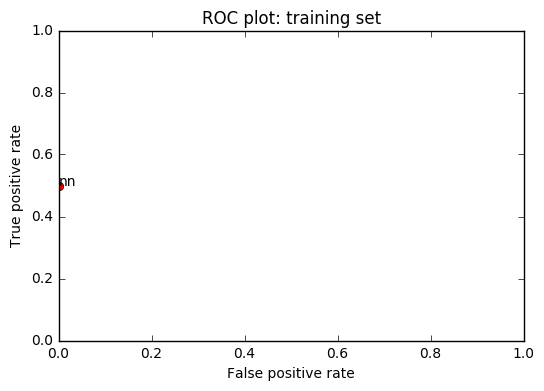

In [18]:
fits = [nn_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()